# Final Capstone Project
## Best location for an Italian restaurant among top US cities

#### by Ignacio de Juan
#### November 2020, Final Project Assignment for IBM Data Science Course

### 1. Introduction / Business Problem

We need to take the decision of where is the best location to open a new restaurant of a certain cuisine type in a top city of the USA. In this case it will be Italian cuisine.

The decision of opening a new restaurant should take into consideration the competition, demand and likelihood of success taken into account as much information available.

Through this exercise we will address the following questions:

- Which are the cities with a highest potential based on the level of concentration of these type of restaurants?
- Is the size of the local Italian descent community a variable that affects the number of Italian restaurants? 
- What other factors should we take into account for such a decision? size of the city, other cuisine competition?

With the aid of Wikipedia tables and the Foursquare API we will navigate through the data, looking for insights and arguments to help our final decision.  

Lastly, we will point out the caveats and potential further developments of this exercise.

*Target Audience*

This analysis can be of interest to entrepreneurs, investors and corporates that are considering the set-up of a new business or the expansion of their current one. The provided framework can be useful to determine where to open the restaurant and what strategy should be followed.

### 2. Data

We will take data from top US cities, ranked by population. The reason for taking the largest cities is to achieve a sufficiently large dataset to draw valid conclusions. We will be using Wikipedia to identify the target cities of our study.

Foursquare will serve as our database for the restaurant data. 

In the following sections we describe in practical terms, with examples, how is this information obtained and put in the right format to be used in the subsequent analysis phase.

### 3. Methodology

#### Set up

In [46]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


%matplotlib inline
mpl.style.use(['seaborn'])

# !pip install python-dotenv

# Credentials file
%load_ext dotenv
%dotenv

import os

import json

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


pd.set_option("display.max_rows", None, "display.max_columns", None)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


#### Retrieving the Data 

##### US cities data

We retrieve the list of US cities with their population and other relevant data

Source: Wikipedia, https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [47]:
# Code to retrieve the cities

url = 'https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population'
dfs = pd.read_html(url)

print(len(dfs))

print(dfs[3])

df = dfs[3]

11
     2019rank               City              State[c]  2019estimate  \
0           1   New York City[d]              New York       8336817   
1           2        Los Angeles            California       3979576   
2           3            Chicago              Illinois       2693976   
3           4         Houston[3]                 Texas       2320268   
4           5            Phoenix               Arizona       1680992   
5           6    Philadelphia[e]          Pennsylvania       1584064   
6           7        San Antonio                 Texas       1547253   
7           8          San Diego            California       1423851   
8           9             Dallas                 Texas       1343573   
9          10           San Jose            California       1021795   
10         11             Austin                 Texas        978908   
11         12    Jacksonville[f]               Florida        911507   
12         13         Fort Worth                 Texas       

Next, we will clean the city names to make them standard and usable in our queries to Foursquare API. 

In [48]:
df['City'] = df['City'].str.replace("\[.*\]","")
df['2016 population density.1'] = df['2016 population density.1'].str.replace("/km2","")
df['2016 population density.1'] = df['2016 population density.1'].str.replace(",","")
df.head()

,2019rank,City,State[c],2019estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York City,New York,8336817,8175133,+1.98%,301.5 sq mi,780.9 km2,"28,317/sq mi",10933,40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3979576,3792621,+4.93%,468.7 sq mi,"1,213.9 km2","8,484/sq mi",3276,34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2693976,2695598,−0.06%,227.3 sq mi,588.7 km2,"11,900/sq mi",4600,41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston,Texas,2320268,2100263,+10.48%,637.5 sq mi,"1,651.1 km2","3,613/sq mi",1395,29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1680992,1445632,+16.28%,517.6 sq mi,"1,340.6 km2","3,120/sq mi",1200,33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


In [49]:
df = df[["City","State[c]","2019estimate","2016 population density.1"]]
df.head()

,City,State[c],2019estimate,2016 population density.1
0,New York City,New York,8336817,10933
1,Los Angeles,California,3979576,3276
2,Chicago,Illinois,2693976,4600
3,Houston,Texas,2320268,1395
4,Phoenix,Arizona,1680992,1200


In [50]:
df.rename(columns={"State[c]":"State","2019estimate":"Population","2016 population density.1":"Population density"},inplace = True)
df = df.assign(Population = round(df["Population"]/1000000,1))
df.head()

/Users/idejuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,City,State,Population,Population density
0,New York City,New York,8.3,10933
1,Los Angeles,California,4.0,3276
2,Chicago,Illinois,2.7,4600
3,Houston,Texas,2.3,1395
4,Phoenix,Arizona,1.7,1200


In [51]:
# The scope of the analysis will be the top 100 cities ranked by population
cities = list(df['City'][0:100])
print(cities)

['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte', 'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington', 'Boston', 'El Paso', 'Nashville', 'Detroit', 'Oklahoma City', 'Portland', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore', 'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Mesa', 'Sacramento', 'Atlanta', 'Kansas City', 'Colorado Springs', 'Omaha', 'Raleigh', 'Miami', 'Long Beach', 'Virginia Beach', 'Oakland', 'Minneapolis', 'Tulsa', 'Tampa', 'Arlington', 'New Orleans', 'Wichita', 'Bakersfield', 'Cleveland', 'Aurora', 'Anaheim', 'Honolulu', 'Santa Ana', 'Riverside', 'Corpus Christi', 'Lexington', 'Henderson', 'Stockton', 'Saint Paul', 'Cincinnati', 'St. Louis', 'Pittsburgh', 'Greensboro', 'Lincoln', 'Anchorage', 'Plano', 'Orlando', 'Irvine', 'Newark', 'Durham', 'Chula Vista', 'Toledo', 'Fort Wayne', 'St. Petersburg', 'Laredo

##### Retrieving venue data from Foursquare

In [52]:
# Foursquare API credentials and endpoint
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
VERSION = '20200616'
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)

We will now load the types of cuisines available in Foursquare.  
Source: https://developer.foursquare.com/docs/build-with-foursquare/categories

In [53]:
cuisines = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f', 
    'Himalayan': '52e81612bcbc57f1066b79fb', 
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Tibetan': '52af39fb3cf9994f4e043be9', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Australian': '4bf58dd8d48988d169941735', 
    'Austrian': '52e81612bcbc57f1066b7a01', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Belgian': '52e81612bcbc57f1066b7a02', 
    'Caribbean': '4bf58dd8d48988d144941735', 
    'Caucasian': '5293a7d53cf9994f4e043a45', 
    'Czech': '52f2ae52bcbc57f1066b8b81', 
    'Dutch': '5744ccdfe4b0c0459246b4d0', 
    'Belarusian': '52e928d0bcbc57f1066b7e97', 
    'Bosnian': '58daa1558bbb0b01f18ec1ee', 
    'Bulgarian': '56aa371be4b08b9a8d5734f3', 
    'Romanian': '52960bac3cf9994f4e043ac4', 
    'Tatar': '52e928d0bcbc57f1066b7e98', 
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Greek': '4bf58dd8d48988d10e941735', 
    'Hawaiian': '52e81612bcbc57f1066b79fe', 
    'Hungarian': '52e81612bcbc57f1066b79fa', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735', 
    'Salvadoran': '5745c7ac498e5d0483112fdb', 
    'Argentinian': '4bf58dd8d48988d107941735', 
    'Brazilian': '4bf58dd8d48988d16b941735', 
    'Colombian': '58daa1558bbb0b01f18ec1f4', 
    'Peruvian': '4eb1bfa43b7b52c0e1adc2e8', 
    'Venezuelan': '56aa371be4b08b9a8d573558', 
    'Moroccan': '4bf58dd8d48988d1c3941735', 
    'Mexican': '4bf58dd8d48988d1c1941735', 
    'Egyptian': '5bae9231bedf3950379f89e1', 
    'Iraqi': '5bae9231bedf3950379f89e7', 
    'Israeli': '56aa371be4b08b9a8d573529', 
    'Kurdish': '5744ccdfe4b0c0459246b4ca', 
    'Lebanese': '58daa1558bbb0b01f18ec1cd', 
    'Persian': '52e81612bcbc57f1066b79f7', 
    'Syrian': '5bae9231bedf3950379f89da', 
    'Yemeni': '5bae9231bedf3950379f89ea', 
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Polish': '52e81612bcbc57f1066b7a04', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44', 
    'Scandinavian': '4bf58dd8d48988d1c6941735', 
    'Scottish': '5744ccdde4b0c0459246b4a3', 
    'Slovak': '56aa371be4b08b9a8d57355a', 
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Swiss': '4bf58dd8d48988d158941735', 
    'Turkish': '4f04af1f2fb6e1c99f3db0bb', 
    'Ukranian': '52e928d0bcbc57f1066b7e96'
}

We continue with the code to retrieve all the restaurants for each city and cuisine

In [54]:
# Important: In order to avoid loading the data from the Foursquare API every time the notebook is reloaded, we can download the data to a .csv file once and then reuse it. 
# Write DataFrame to CSV, use the first time you want to download the DataFrame to a CSV
#restaurants.to_csv('restaurants.csv', index=False)

read_local_file = True


if (read_local_file == True):
    restaurants_from_csv = pd.read_csv('restaurants.csv', keep_default_na=False, na_values=[""])
    restaurants = restaurants_from_csv
else:
    restaurants = pd.DataFrame(columns=['City', 'Cuisine', 'Total restaurants'])
    for city in cities:
        print(city)
        for cuisine_name, category_id in cuisines.items():
            # For each city, retrieve the top restaurants from Foursquare for each cuisine...
            query = requests.get("{url}&near={city}&categoryId={category_id}".format(url=URL, city=city, category_id=category_id))
            if query.status_code == 200:
                number = query.json()
                restaurants = restaurants.append({
                    'City': city,
                    'Cuisine': cuisine_name,
                    'Total restaurants': number['response']['totalResults']
                }, ignore_index=True)
        
restaurants

,City,Cuisine,Total restaurants
0,New York City,Afghan,13
1,New York City,African,91
2,New York City,American,375
3,New York City,Burmese,9
4,New York City,Cambodian,9
5,New York City,Chinese,350
6,New York City,Filipino,23
7,New York City,Himalayan,12
8,New York City,Indonesian,14
9,New York City,Japanese,340


In [55]:
# Let's see what cities have been properly downloaded
len(np.unique(restaurants['City']))

93

For some reason, after several attemps, Foursquare API does only respond with data for 14 cities. It looks like there is a limitation from Foursquare. Let's continue with it.    
We will calculate the total restaurants per city.

In [56]:
# Count the diversity of cuisines per city
restaurants['Diversity'] = restaurants['Total restaurants']>0
restaurants.head(100)

restaurants[['City','Diversity']].groupby('City').sum().reset_index().sort_values(by = 'Diversity', ascending = False)


,City,Diversity
51,Memphis,65.0
57,New York City,61.0
41,Jersey City,60.0
14,Chicago,57.0
78,San Francisco,54.0
48,Los Angeles,53.0
65,Philadelphia,52.0
69,Portland,52.0
61,Oakland,52.0
85,St. Petersburg,52.0


In [57]:
restaurants.head()

,City,Cuisine,Total restaurants,Diversity
0,New York City,Afghan,13,True
1,New York City,African,91,True
2,New York City,American,375,True
3,New York City,Burmese,9,True
4,New York City,Cambodian,9,True


In [58]:
restaurants_total = restaurants.groupby('City').sum().reset_index()
restaurants_total.head()

,City,Total restaurants,Diversity
0,Anaheim,1451,48.0
1,Anchorage,413,26.0
2,Arlington,1114,46.0
3,Atlanta,1940,44.0
4,Aurora,1011,47.0


In [59]:
df_cities = pd.merge(restaurants_total, df, on='City')
df_cities.sort_values('Population', ascending = False)

,City,Total restaurants,Diversity,State,Population,Population density
61,New York City,5493,61.0,New York,8.3,10933
52,Los Angeles,3929,53.0,California,4.0,3276
15,Chicago,3210,57.0,Illinois,2.7,4600
39,Houston,2959,48.0,Texas,2.3,1395
70,Phoenix,1612,45.0,Arizona,1.7,1200
69,Philadelphia,2457,52.0,Pennsylvania,1.6,4511
81,San Antonio,1596,44.0,Texas,1.5,1250
82,San Diego,2350,45.0,California,1.4,1670
23,Dallas,2216,51.0,Texas,1.3,1493
6,Austin,1640,50.0,Texas,1.0,1170


#### Exploring the Data

We can now make some preliminary data evaluation on the dataset, such as looking at the amount of restaurants against the population figures:

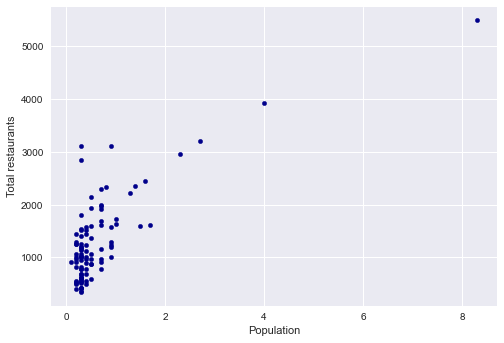

In [60]:
ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue')

This chart shows that the higher the population, the more restaurants there are in Foursquare. 

We can see the data is quite consistent, since the larger the city, more restaurants we will find. 
Let's see if this trend is the same for the Italian restaurants

In [61]:
#italian_restaurants = restaurants[restaurants['Cuisine']=='Italian']
italian_restaurants = restaurants[restaurants['Cuisine']=='Italian'].copy()
italian_restaurants.drop(columns = ['Diversity'], inplace = True)
italian_restaurants.rename(columns = {'Total restaurants':'Italian restaurants'}, inplace = True)
italian_restaurants

,City,Cuisine,Italian restaurants
36,New York City,Italian,334
100,Los Angeles,Italian,195
165,Chicago,Italian,214
230,Houston,Italian,164
295,Phoenix,Italian,130
360,Philadelphia,Italian,168
425,San Antonio,Italian,111
490,San Diego,Italian,153
555,Dallas,Italian,129
620,San Jose,Italian,56


In [62]:
df_cities = pd.merge(df_cities, italian_restaurants, on='City')
list(df_cities.columns)

['City',
 'Total restaurants',
 'Diversity',
 'State',
 'Population',
 'Population density',
 'Cuisine',
 'Italian restaurants']

In [63]:
df_cities = df_cities[["City","Total restaurants","Italian restaurants","Diversity","State","Population"]]
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population
0,Anaheim,1451,22,48.0,California,0.4
1,Anchorage,413,22,26.0,Alaska,0.3
2,Arlington,1114,24,46.0,Texas,0.4
3,Atlanta,1940,118,44.0,Georgia,0.5
4,Aurora,1011,68,47.0,Colorado,0.4
5,Aurora,1011,68,47.0,Illinois,0.2
6,Austin,1640,128,50.0,Texas,1.0
7,Bakersfield,557,21,25.0,California,0.4
8,Baton Rouge,531,36,25.0,Louisiana,0.2
9,Boise,551,28,32.0,Idaho,0.2


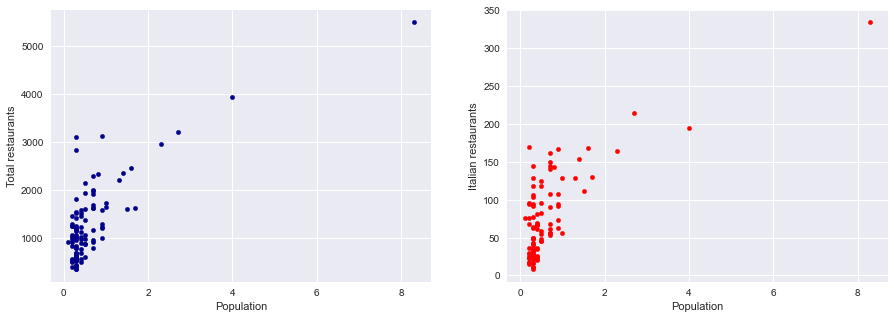

In [64]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)


ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue',figsize = (15,5), ax = ax1)

ax2 = df_cities.plot.scatter(x='Population',
                      y='Italian restaurants',
                      c='Red',figsize = (15,5), ax = ax2)

#### Ratings for Italian cuisine restaurants

In [65]:
# List with ratings downloaded from Foursquare
ratings_avg_italian_restaurants = [['Albuquerque', 7.36],
 ['Anaheim', 8.27],
 ['Anchorage', 7.2],
 ['Arlington', 8.18],
 ['Atlanta', 8.41],
 ['Aurora', 8.6],
 ['Austin', 8.05],
 ['Bakersfield', 7.33],
 ['Baltimore', 8.26],
 ['Boston', 8.58],
 ['Buffalo', 8.09],
 ['Chandler', 8.77],
 ['Charlotte', 8.0],
 ['Chicago', 8.79],
 ['Chula Vista', 8.58],
 ['Cincinnati', 7.79],
 ['Cleveland', 8.04],
 ['Colorado Springs', 8.07],
 ['Columbus', 7.93],
 ['Corpus Christi', 7.54],
 ['Dallas', 8.09],
 ['Denver', 8.32],
 ['Detroit', 8.12],
 ['Durham', 7.82],
 ['El Paso', 7.89],
 ['Fort Wayne', 7.54],
 ['Fort Worth', 7.97],
 ['Fresno', 7.35],
 ['Gilbert', 8.61],
 ['Glendale', 8.77],
 ['Greensboro', 7.53],
 ['Henderson', 8.66],
 ['Honolulu', 7.03],
 ['Houston', 8.37],
 ['Indianapolis', 7.76],
 ['Irvine', 8.29],
 ['Jacksonville', 7.67],
 ['Jersey City', 9.24],
 ['Kansas City', 8.23],
 ['Laredo', 7.68],
 ['Las Vegas', 8.57],
 ['Lexington', 7.71],
 ['Lincoln', 7.55],
 ['Long Beach', 8.6],
 ['Los Angeles', 8.88],
 ['Louisville', 7.48],
 ['Lubbock', 7.59],
 ['Madison', 7.16],
 ['Memphis', 7.29],
 ['Mesa', 8.77],
 ['Miami', 8.83],
 ['Milwaukee', 7.99],
 ['Minneapolis', 8.48],
 ['Nashville', 8.01],
 ['New Orleans', 8.02],
 ['New York City', 9.19],
 ['Newark', 9.23],
 ['North Las Vegas', 8.69],
 ['Oakland', 8.89],
 ['Oklahoma City', 7.54],
 ['Omaha', 7.36],
 ['Orlando', 8.55],
 ['Philadelphia', 8.64],
 ['Phoenix', 8.79],
 ['Pittsburgh', 8.51],
 ['Plano', 8.67],
 ['Portland', 7.88],
 ['Raleigh', 7.8],
 ['Reno', 6.6],
 ['Riverside', 7.47],
 ['Sacramento', 7.69],
 ['Saint Paul', 8.27],
 ['San Antonio', 7.92],
 ['San Diego', 8.47],
 ['San Francisco', 8.75],
 ['San Jose', 7.69],
 ['Santa Ana', 8.41],
 ['Scottsdale', 8.75],
 ['Seattle', 8.28],
 ['St. Louis', 8.38],
 ['St. Petersburg', 8.05],
 ['Stockton', 6.98],
 ['Tampa', 8.35],
 ['Toledo', 7.89],
 ['Tucson', 6.98],
 ['Tulsa', 7.94],
 ['Virginia Beach', 7.48],
 ['Washington', 8.59],
 ['Wichita', 7.93]]

# We convert the list to a DataFrame

df_ratings_avg_italian_restaurants = pd.DataFrame(ratings_avg_italian_restaurants, columns = ['City','Rating'])
df_ratings_avg_italian_restaurants.head()

,City,Rating
0,Albuquerque,7.36
1,Anaheim,8.27
2,Anchorage,7.20
3,Arlington,8.18
4,Atlanta,8.41


In [66]:
# Now we can merge the contents with the master dataframe
df_cities = pd.merge(df_cities, df_ratings_avg_italian_restaurants, on='City')
df_cities.head()


,City,Total restaurants,Italian restaurants,Diversity,State,Population,Rating
0,Anaheim,1451,22,48.0,California,0.4,8.27
1,Anchorage,413,22,26.0,Alaska,0.3,7.20
2,Arlington,1114,24,46.0,Texas,0.4,8.18
3,Atlanta,1940,118,44.0,Georgia,0.5,8.41
4,Aurora,1011,68,47.0,Colorado,0.4,8.60


#### Population from Italian descent

Let's look at the percentage of population from Italian descent. 
Source: https://en.wikipedia.org/wiki/Italian_Americans#U.S._states_with_over_10%_people_of_Italian_ancestry

In [67]:
italian_origin = {'Alabama' : 1.7,
            'Alaska' : 3.3,
            'Arizona' : 4.4,
            'Arkansas' : 1.6,
            'California' : 4.0,
            'Colorado' : 5.1,
            'Connecticut' : 18.7,
            'Delaware': 9.9,
            'Florida' : 6.2,
            'Georgia' : 2.2,
            'Hawaii' : 2.1,
            'Idaho' : 3.2,
            'Illinois' : 6.2,
            'Indiana' : 2.7,
            'Iowa' : 2.1,
            'Kansas' : 2.3,
            'Kentucky' : 2.0,
            'Louisiana' : 4.8,
            'Maine' : 5.6,
            'Maryland' : 5.2,
            'Massachusetts' : 13.9,
            'Michigan' : 4.7,
            'Minnesota' : 2.3,
            'Mississippi' : 1.8,
            'Missouri' : 3.4,
            'Montana' : 3.5,
            'Nebraska' : 2.8,
            'Nevada' : 6.3,
            'New Hampshire' : 10.3,
            'New Jersey' : 16.8,
            'New Mexico' : 2.4,
            'New York' : 13.5,
            'North Carolina' : 3.0,
            'North Dakota' : 1.2,
            'Ohio' : 6.4,
            'Oklahoma' : 1.7,
            'Oregon' : 3.8,
            'Pennsylvania' : 12.2,
            'Rhode Island' : 18.9,
            'South Carolina' : 2.9,
            'South Dakota' : 1.4,
            'Tennessee' : 2.2,
            'Texas' : 1.9,
            'Utah' : 2.7,
            'Vermont' : 7.4,
            'Virginia' : 4.0,
            'Washington' : 3.6,
            'West Virginia' : 4.7,
            'Wisconsin' : 3.5,
            'Wyoming' : 3.1,
            'District of Columbia' : 3.3}


df_italian_origin = pd.DataFrame(list(italian_origin.items()),columns = ['State','Italian origin']) 
df_italian_origin.head()

,State,Italian origin
0,Alabama,1.7
1,Alaska,3.3
2,Arizona,4.4
3,Arkansas,1.6
4,California,4.0


In [68]:
df_cities = pd.merge(df_cities, df_italian_origin, on='State')
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Rating,Italian origin
0,Anaheim,1451,22,48.0,California,0.4,8.27,4.0
1,Bakersfield,557,21,25.0,California,0.4,7.33,4.0
2,Chula Vista,1008,11,42.0,California,0.3,8.58,4.0
3,Glendale,821,29,37.0,California,0.2,8.77,4.0
4,Irvine,1203,25,41.0,California,0.3,8.29,4.0
5,Long Beach,1596,45,46.0,California,0.5,8.60,4.0
6,Los Angeles,3929,195,53.0,California,4.0,8.88,4.0
7,Oakland,1522,36,52.0,California,0.4,8.89,4.0
8,Riverside,1003,32,37.0,California,0.3,7.47,4.0
9,Sacramento,1370,45,42.0,California,0.5,7.69,4.0


End of Data gathering

In [69]:
df_cities.describe()

,Total restaurants,Italian restaurants,Diversity,Population,Rating,Italian origin
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,1355.250000,77.738636,42.329545,0.693182,8.133182,4.593182
std,854.477097,55.036559,9.446427,0.998941,0.551659,3.217009
min,342.000000,8.000000,16.000000,0.200000,6.600000,1.700000
25%,789.250000,34.750000,37.000000,0.300000,7.747500,2.300000
50%,1148.500000,63.500000,43.500000,0.400000,8.105000,4.000000
75%,1615.000000,107.250000,48.000000,0.700000,8.592500,5.375000
max,5493.000000,334.000000,65.000000,8.300000,9.240000,16.800000


In [70]:
df_cities.corr()

,Total restaurants,Italian restaurants,Diversity,Population,Rating,Italian origin
Total restaurants,1.000000,0.846522,0.726065,0.760041,0.550253,0.420082
Italian restaurants,0.846522,1.000000,0.595133,0.738691,0.464596,0.365657
Diversity,0.726065,0.595133,1.000000,0.371388,0.518308,0.321234
Population,0.760041,0.738691,0.371388,1.000000,0.284520,0.224426
Rating,0.550253,0.464596,0.518308,0.284520,1.000000,0.445970
Italian origin,0.420082,0.365657,0.321234,0.224426,0.445970,1.000000


In the above correlation table we can see that the number of restaurants is correlated with population and the number of Italian restaurants less so. The larger the city, more variety of food, what results into less weighting of Italian restaurants.

### Calculations

In [71]:

df_cities['italian_rest_perc'] = round(df_cities['Italian restaurants']/df_cities['Total restaurants']*100,1)
df_cities
df_cities['italian_rest_per_m_pop']=round(df_cities['Italian restaurants']/(df_cities['Population']*1000),2)
df_cities['total_rest_per_m_pop']=round(df_cities['Total restaurants']/(df_cities['Population']*1000),2)
df_cities['Other restaurants'] = df_cities['Total restaurants'] - df_cities['Italian restaurants']


In [72]:
df_cities.head()

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
0,Anaheim,1451,22,48.0,California,0.4,8.27,4.0,1.5,0.06,3.63,1429
1,Bakersfield,557,21,25.0,California,0.4,7.33,4.0,3.8,0.05,1.39,536
2,Chula Vista,1008,11,42.0,California,0.3,8.58,4.0,1.1,0.04,3.36,997
3,Glendale,821,29,37.0,California,0.2,8.77,4.0,3.5,0.14,4.11,792
4,Irvine,1203,25,41.0,California,0.3,8.29,4.0,2.1,0.08,4.01,1178


In [73]:
df_cities.corr()

,Total restaurants,Italian restaurants,Diversity,Population,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
Total restaurants,1.000000,0.846522,0.726065,0.760041,0.550253,0.420082,-0.049404,0.071557,0.198116,0.999343
Italian restaurants,0.846522,1.000000,0.595133,0.738691,0.464596,0.365657,0.443800,0.277315,-0.016559,0.826672
Diversity,0.726065,0.595133,1.000000,0.371388,0.518308,0.321234,-0.038545,0.234099,0.343860,0.726915
Population,0.760041,0.738691,0.371388,1.000000,0.284520,0.224426,0.063108,-0.252447,-0.316006,0.753054
Rating,0.550253,0.464596,0.518308,0.284520,1.000000,0.445970,-0.020319,0.275918,0.404548,0.549973
Italian origin,0.420082,0.365657,0.321234,0.224426,0.445970,1.000000,0.098233,0.298803,0.435821,0.419122
italian_rest_perc,-0.049404,0.443800,-0.038545,0.063108,-0.020319,0.098233,1.000000,0.516728,-0.199347,-0.082433
italian_rest_per_m_pop,0.071557,0.277315,0.234099,-0.252447,0.275918,0.298803,0.516728,1.000000,0.663818,0.056754
total_rest_per_m_pop,0.198116,-0.016559,0.343860,-0.316006,0.404548,0.435821,-0.199347,0.663818,1.000000,0.210530
Other restaurants,0.999343,0.826672,0.726915,0.753054,0.549973,0.419122,-0.082433,0.056754,0.210530,1.000000


Let's highlight the interesting correlations derived from the above table, bearing in mind that correlation means assotiation, not causation:

Weak correlations (0.3 < r < 0.5):
- Italian origin has some correlation with the number of restaurants per thousand inhabitants, but it is higher with the total number (0.43) than the number of Italian restaurants (0.30). This means that the amount of Italian origin population is not a driver for having more Italian restaurants.

Moderate correlation (0.5 < r < 0.7):
- Rating and Total restaurants. This could be caused by the fact that more competition implies higher quality. For our study, this means that it will be easier to succeed in a city with less number of restaurants.

Strong correlation ( r > 0.7):
- Total restaurants and Diversity
- Total restaurants and Italian restaurants


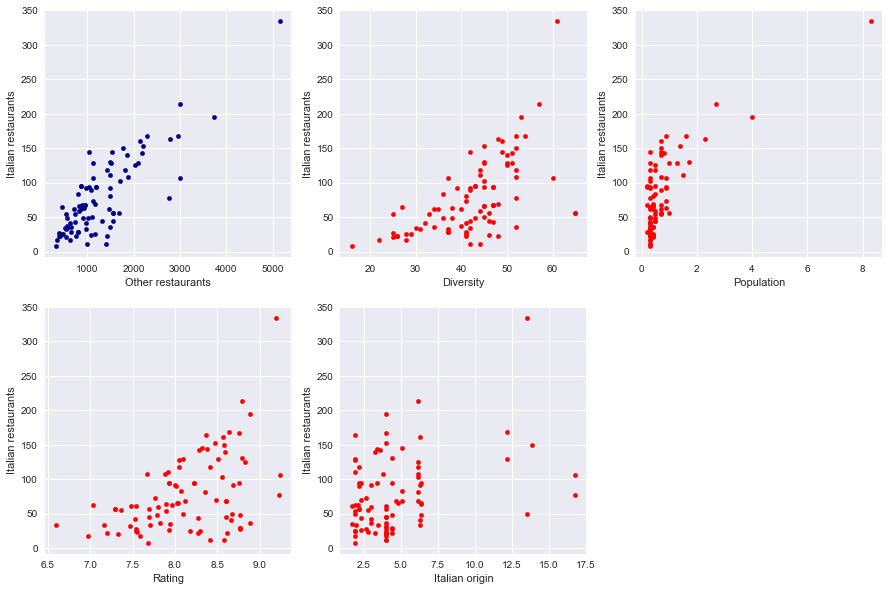

In [74]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(231)

# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(232)

ax3 = fig.add_subplot(233)

ax4 = fig.add_subplot(234)

ax5 = fig.add_subplot(235)

ax1 = df_cities.plot.scatter(x='Other restaurants',
                      y='Italian restaurants',
                      c='DarkBlue',figsize = (15,10), ax = ax1)

ax2 = df_cities.plot.scatter(x='Diversity',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax2)

ax3 = df_cities.plot.scatter(x='Population',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax3)

ax4 = df_cities.plot.scatter(x='Rating',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax4)

ax5 = df_cities.plot.scatter(x='Italian origin',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1295e3250>,
      dtype=object)

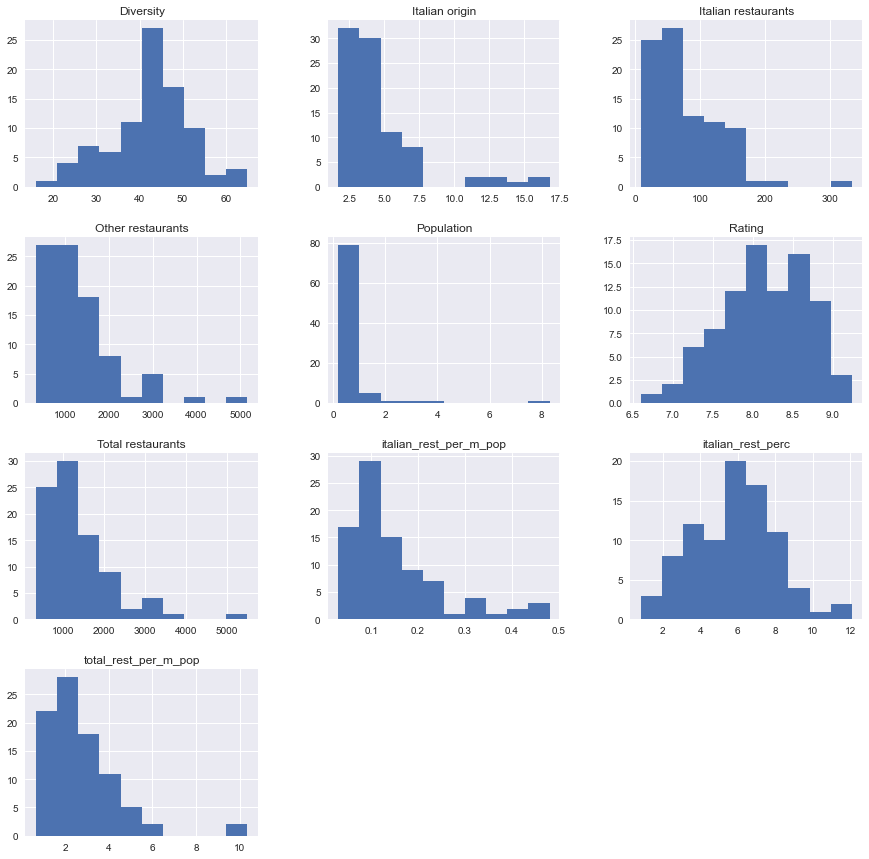

In [75]:
df_cities.hist(figsize = (15,15))

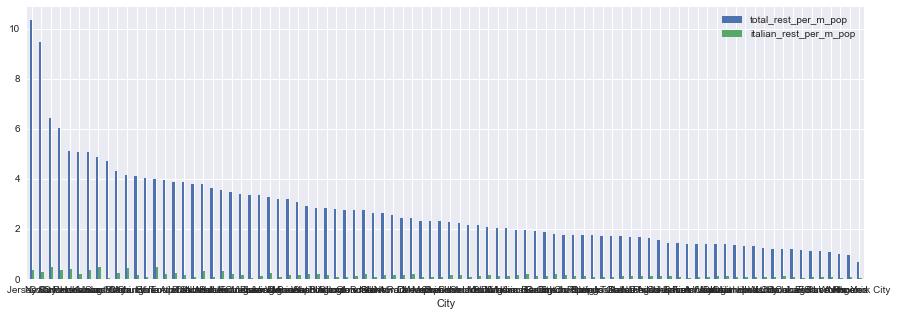

In [76]:
ax3 = df_cities.sort_values('total_rest_per_m_pop', ascending = False).plot.bar(x = 'City',y =['total_rest_per_m_pop','italian_rest_per_m_pop'],rot=0, figsize = (15,5), sort_columns = True)

This concludes the Data section of this project. In the next sections we will discuss and further analyse the datasets.

,City,italian_rest_perc,Italian origin,Population
0,Anaheim,1.5,4.0,0.4
1,Bakersfield,3.8,4.0,0.4
2,Chula Vista,1.1,4.0,0.3
3,Glendale,3.5,4.0,0.2
4,Irvine,2.1,4.0,0.3
5,Long Beach,2.8,4.0,0.5
6,Los Angeles,5.0,4.0,4.0
7,Oakland,2.4,4.0,0.4
8,Riverside,3.2,4.0,0.3
9,Sacramento,3.3,4.0,0.5


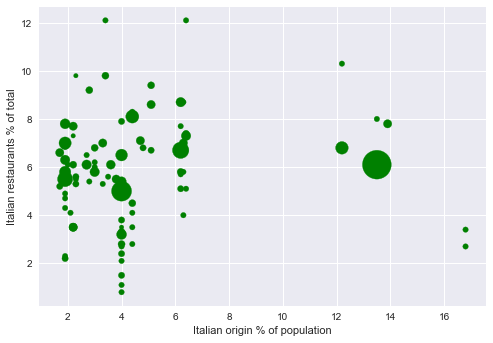

In [77]:
df_cities['bubble_size']=df_cities['Population']*100

ax4 = plt.scatter(x='Italian origin',
                      y='italian_rest_perc',s='bubble_size',
                      c='Green', data=df_cities)
plt.xlabel("Italian origin % of population")
plt.ylabel("Italian restaurants % of total")
df_cities[['City','italian_rest_perc','Italian origin','Population']]

Text(0, 0.5, 'Ratings for Italian restaurants')

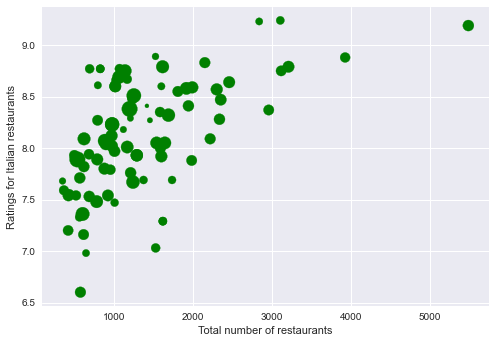

In [78]:
df_cities['bsize'] = df_cities['italian_rest_perc']*20

ax5 = plt.scatter(x='Total restaurants',
                      y='Rating',
                      c='Green', s='bsize',data=df_cities)
plt.xlabel("Total number of restaurants")
plt.ylabel("Ratings for Italian restaurants")

In [79]:
df_cities[['City','italian_rest_perc','Italian origin','Population','State']].sort_values(by = 'State')

,City,italian_rest_perc,Italian origin,Population,State
15,Anchorage,5.3,3.3,0.3,Alaska
37,Chandler,4.1,4.4,0.3,Arizona
38,Gilbert,2.8,4.4,0.3,Arizona
39,Glendale,3.5,4.4,0.3,Arizona
40,Mesa,4.5,4.4,0.5,Arizona
41,Phoenix,8.1,4.4,1.7,Arizona
42,Scottsdale,8.3,4.4,0.3,Arizona
0,Anaheim,1.5,4.0,0.4,California
14,Stockton,2.7,4.0,0.3,California
13,Santa Ana,0.8,4.0,0.3,California


Text(0, 0.5, 'italian_rest_per_m_pop')

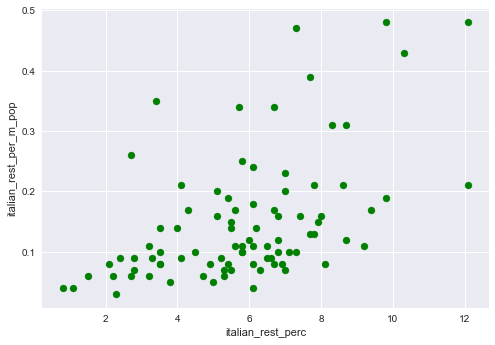

In [80]:
ax6 = plt.scatter(x='italian_rest_perc',
                      y='italian_rest_per_m_pop',
                      c='Green', data=df_cities)
plt.xlabel("italian_rest_perc")
plt.ylabel("italian_rest_per_m_pop")

In [81]:
df_cities.head()

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants,bubble_size,bsize
0,Anaheim,1451,22,48.0,California,0.4,8.27,4.0,1.5,0.06,3.63,1429,40.0,30.0
1,Bakersfield,557,21,25.0,California,0.4,7.33,4.0,3.8,0.05,1.39,536,40.0,76.0
2,Chula Vista,1008,11,42.0,California,0.3,8.58,4.0,1.1,0.04,3.36,997,30.0,22.0
3,Glendale,821,29,37.0,California,0.2,8.77,4.0,3.5,0.14,4.11,792,20.0,70.0
4,Irvine,1203,25,41.0,California,0.3,8.29,4.0,2.1,0.08,4.01,1178,30.0,42.0


In [82]:
df_cities['Rating'][0]**1/3

2.7566666666666664

Text(0, 0.5, 'total_rest_per_m_pop')

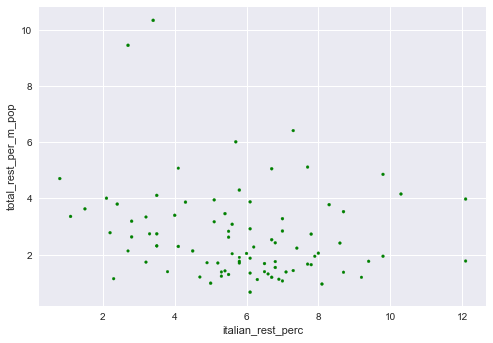

In [83]:
df_cities['bubble_rating'] = df_cities['Rating']
ax6 = plt.scatter(x='italian_rest_perc',
                      y='total_rest_per_m_pop',s = 'bubble_rating',
                      c='Green', data=df_cities)
plt.xlabel("italian_rest_perc")
plt.ylabel("total_rest_per_m_pop")

The above chart shows on the Y axis the amount of restaurants per thousand inhabitants, and the X axis the percentage of Italian restaurants. 
The attractive market is where the Y axis is low, with low level of saturation of restaurants, and the X axis low as well, so there are less Italian restaurants and this means there is room for more.  
Besides, we are going to rank the target space by ratings, so we can identify the cities where the ratings are lower, so it is going to be easier to face competition when we land with our new Italian restaurants.  
We will start with the cities with less than 4 restaurants per 1000 inhabitants, and less or equal than 4% of Italian restaurants.

In [160]:
#df.loc[(df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
df_target = df_cities.loc[(df_cities['total_rest_per_m_pop'] < 4)  & (df_cities['italian_rest_perc'] <= 4),['City','State','Italian restaurants','total_rest_per_m_pop','italian_rest_perc','Rating']].sort_values(by = 'Rating')

df_target



,City,State,Italian restaurants,total_rest_per_m_pop,italian_rest_perc,Rating
14,Stockton,California,17,2.13,2.7,6.98
74,Memphis,Tennessee,56,2.31,3.5,7.29
75,Memphis,Tennessee,56,2.31,3.5,7.29
1,Bakersfield,California,21,1.39,3.8,7.33
8,Riverside,California,32,3.34,3.2,7.47
23,Laredo,Texas,8,1.14,2.3,7.68
9,Sacramento,California,45,2.74,3.3,7.69
12,San Jose,California,56,1.73,3.2,7.69
16,Arlington,Texas,24,2.78,2.2,8.18
0,Anaheim,California,22,3.63,1.5,8.27


In [166]:
target_index_list = df_target.index.to_list()
print(target_index_list)

[14, 74, 75, 1, 8, 23, 9, 12, 16, 0, 2, 5, 38, 54, 39, 7]


### Results

xxxx

### Multiple Linear Regression

In [144]:
from sklearn.preprocessing import MinMaxScaler

# Selecting the features for regression
cols = ['Other restaurants','Italian restaurants','Diversity','Population','Rating','Italian origin']
df_cities_r = df_cities[cols].copy()


cols_x = ['Other restaurants', 'Diversity','Population','Rating','Italian origin']

# Scaling the dataset

x = np.asanyarray(df_cities_r[['Other restaurants','Diversity','Population','Rating','Italian origin']])
scaler_x = MinMaxScaler().fit(x)


y = np.asanyarray(df_cities_r[['Italian restaurants']])
scaler_y = MinMaxScaler().fit(y)


#df_cities_r[cols] = min_max_scaler.fit_transform(df_cities_r[cols])




df_cities_r.head()


,Other restaurants,Italian restaurants,Diversity,Population,Rating,Italian origin
0,1429,22,48.0,0.4,8.27,4.0
1,536,21,25.0,0.4,7.33,4.0
2,997,11,42.0,0.3,8.58,4.0
3,792,29,37.0,0.2,8.77,4.0
4,1178,25,41.0,0.3,8.29,4.0


In [149]:
print(x[14])

[6.23e+02 2.80e+01 3.00e-01 6.98e+00 4.00e+00]


In [131]:

# Creating train and test dataset

msk = np.random.rand(len(df_cities)) < 0.8
train = df_cities_r[msk]
test = df_cities_r[~msk]

# Multiple Regression Model

from sklearn import linear_model
from sklearn import metrics
regr = linear_model.LinearRegression()
x_train = scaler_x.transform(np.asanyarray(train[['Other restaurants','Diversity','Population','Rating','Italian origin']]))
y_train = scaler_y.transform(np.asanyarray(train[['Italian restaurants']]))
regr.fit (x_train, y_train)
# The coefficients
print ('Coefficients: ', regr.coef_)
# Coefficients:  [[0.45693203 0.06279319 0.4804892  0.06439731 0.02770891]]

Coefficients:  [[0.54944601 0.0208722  0.37389105 0.0500268  0.03858604]]


In [133]:
# Prediction
x_test = scaler_x.transform(np.asanyarray(test[['Other restaurants','Diversity','Population','Rating','Italian origin']]))
y_test = scaler_y.transform(np.asanyarray(test[['Italian restaurants']]))
y_hat= regr.predict(x_test)

print("Residual sum of squares: %.2f"% np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % metrics.explained_variance_score(y_test, y_hat))
print('Other variance score',regr.score(x_test,y_test))
# R2
accuracy_lr = metrics.r2_score(y_test, y_hat)
print('R-square:',accuracy_lr)


Residual sum of squares: 0.01
Variance score: 0.60
Other variance score 0.5903702535829816
R-square: 0.5903702535829816


In [134]:
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.54944601 0.0208722  0.37389105 0.0500268  0.03858604]]


In [199]:
#regr.predict(x[[0]])
predicted_number_italian_rest = scaler_y.inverse_transform(regr.predict(scaler_x.transform(x[target_index_list])))
#print(predicted_number_italian_rest)


print(len(predicted_number_italian_rest))
df_target.shape

df_target['predicted_rest'] = predicted_number_italian_rest
df_target['predicted_rest'] = df_target['predicted_rest'].astype(int)
df_target.head()
#print(scaler_x.inverse_transform(x[[14]]))
#scaler_y.inverse_transform(regr.predict(x[[14]]))
df_target['predicted_gap'] = df_target['predicted_rest']-df_target['Italian restaurants']
df_target.sort_values(by = ['predicted_gap'], ascending = False)

16


,City,State,Italian restaurants,total_rest_per_m_pop,italian_rest_perc,Rating,predicted_rest,predicted_gap
0,Anaheim,California,22,3.63,1.5,8.27,80,58
2,Chula Vista,California,11,3.36,1.1,8.58,64,53
7,Oakland,California,36,3.80,2.4,8.89,87,51
5,Long Beach,California,45,3.19,2.8,8.60,88,43
16,Arlington,Texas,24,2.78,2.2,8.18,65,41
12,San Jose,California,56,1.73,3.2,7.69,95,39
38,Gilbert,Arizona,22,2.63,2.8,8.61,56,34
74,Memphis,Tennessee,56,2.31,3.5,7.29,85,29
75,Memphis,Tennessee,56,2.31,3.5,7.29,85,29
9,Sacramento,California,45,2.74,3.3,7.69,74,29


Feature: 0, Score: 0.45693 Other restaurants
Feature: 1, Score: 0.06279 Diversity
Feature: 2, Score: 0.48049 Population
Feature: 3, Score: 0.06440 Rating
Feature: 4, Score: 0.02771 Italian origin


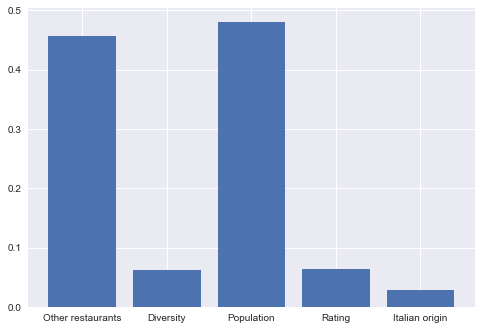

In [89]:
# get importance
importance = regr.coef_[0]
features = ['Other restaurants','Diversity','Population','Rating','Italian origin']
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v), features[i])
# plot feature importance
plt.bar(features, importance)
plt.show()

#### Polynomial Regression

In [136]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Training the model

train_x = scaler_x.transform(np.asanyarray(train[['Other restaurants','Diversity','Population','Rating','Italian origin']]))
train_y = scaler_y.transform(np.asanyarray(train[['Italian restaurants']]))

test_x = scaler_x.transform(np.asanyarray(test[['Other restaurants','Diversity','Population','Rating','Italian origin']]))
test_y = scaler_y.transform(np.asanyarray(test[['Italian restaurants']]))


poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

# Fitting the model

clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)


# Evaluation

from sklearn.metrics import r2_score

test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Coefficients:  [[ 0.         -0.2809624   0.61422554  1.0681905   0.15546055 -0.28842788
  -0.18019915  0.87101566 -1.1114094   1.17935227 -1.88798989 -0.57607544
  -1.42636011 -0.15971219  0.66412969 -0.66193814  0.78835455  2.44683138
  -0.35745765  0.61072119 -0.15813633]]
Intercept:  [-0.06115896]
Mean absolute error: 0.05
Residual sum of squares (MSE): 0.00
R2-score: 0.59


Now we are going to use our prediction model to see how many restaurants should exist in each of the cities. Let's take for example Stockton.

In [140]:
# Predict with multiple linear regression model

#regr.predict(df_cities_r[14])
#regr.predict(df_cities_r.loc[[14]])
#df_cities_r.loc[[14]].values.tolist()
#print(x_train)
print(x[[14]])
#print(scaler_x.inverse_transform(x[[14]]))
scaler_y.inverse_transform(regr.predict(x[[14]]))
#min_max_scaler.inverse_transform(regr.predict(x_train[[0]]))
#min_max_scaler.inverse_transform(df_cities_r.loc[[0]])
#df_cities_r.loc[[0]]


[[6.23e+02 2.80e+01 3.00e-01 6.98e+00 4.00e+00]]


array([[112003.14987693]])

### Discussion

The larger the city, there is more competition among different cuisines, so a good approach would be to look for opportunities in smaller cities that are lagging behind cities of similar size.

Following this approach, a good recommendation would be to look at San Jose, since comparing it to other cities in California, it has less percentage of Italian restaurants.

On the other hand, Philadelphia shows up as a city with potential. A large percentage of Italian origin population in the state could also build up on the same direction of investing in this city.

### Conclusions



#### Further research and caveats of this analysis

##### Caveats
- Foursquare data may be uneven in different cities even if we have chosen all cities in US  
- Ethnic origin of population is at state level, not city level
- The population in the Wikipedia table may refer to a different geography than the geography applied by Foursquare in the queries

##### Further research
- Look at the evolution in time  
- Analyse the preferences of the consumers also in terms of assessment of the existing restaurants  
- Differentiate different level of budget in the restaurants  
- Look at composition of the population and income in the city
- Zoom into the cities that have been selected to better understand the competition, both in geographical terms as well as other types of cuisines. We should make an analysis of the neighbourhoods to identify the best locations for our restaurants.
- Polinomial regression analysis: number or IT rest (y), number of rest, pop size, italian origin, average punctuation feedback